## DA526 - Image Processing with Machine Learning

### CerebraScan: Brain Tumor Segmentation

#### Done By:

- Abhrajyoti Kundu
- Sayan Pal
- Gorachand Mondal
- Prardbh Tiwari

#### Problem Definition:

The task at hand is to perform segmentation of gliomas in pre-operative MRI scans. Each pixel in the image must be labeled with one of the following categories:

1. Not part of a tumor region (0)
2. Part of the enhancing tumor (ET) (1)
3. Part of the tumor core (TC) (2)
4. Part of the whole tumor (WT) (3)

The provided segmentation labels correspond to the following values: 1 for non-enhancing tumor core (NCR) and necrotic or non-enhancing tumor (NET), 2 for the enhancing tumor (ED), 4 for the enhancing tumor (ET), and 0 for everything else.

The goal is to accurately segment the gliomas into these specific categories to assist in pre-operative planning and assessment.


#### Setup environment

In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt



# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# There are 155 slices per volume
# To start at 24 and use 84 slices

VOLUME_SLICES = 84
VOLUME_START_AT = 24 # first slice of volume that we will include

#### About the Dataset

All BraTS multimodal scans are available as NIfTI files (.nii.gz), a commonly used medical imaging format for storing brain imaging data obtained using MRI and describing different MRI settings:

1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with slice thickness ranging from 1 to 6 mm.
2. **T1-CE**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with slice thickness ranging from 2 to 6 mm.
4. **FLAIR**: T2-weighted FLAIR image, acquired axially, coronally, or sagittally in 2D acquisitions, with slice thickness ranging from 2 to 6 mm.

The data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3), and skull-stripped.



Text(0.5, 1.0, 'Mask')

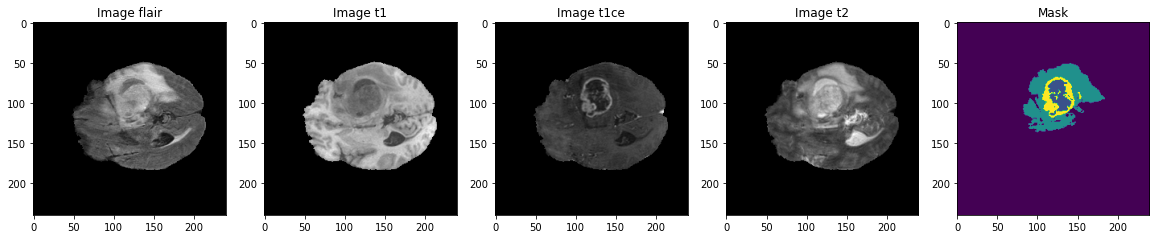

In [3]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 54
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


In [4]:
test_image_flair.shape

(240, 240, 155)

#### Look at each slice FLAIR and SEGMENTED image to take informed decision on which slices to choose for training

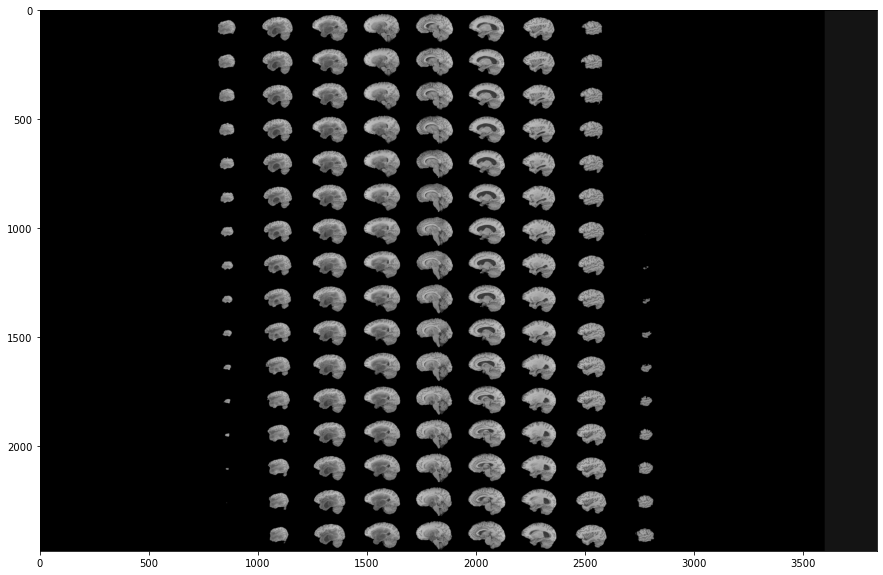

In [5]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[:,:,:]), 90, resize=True), cmap ='gray')

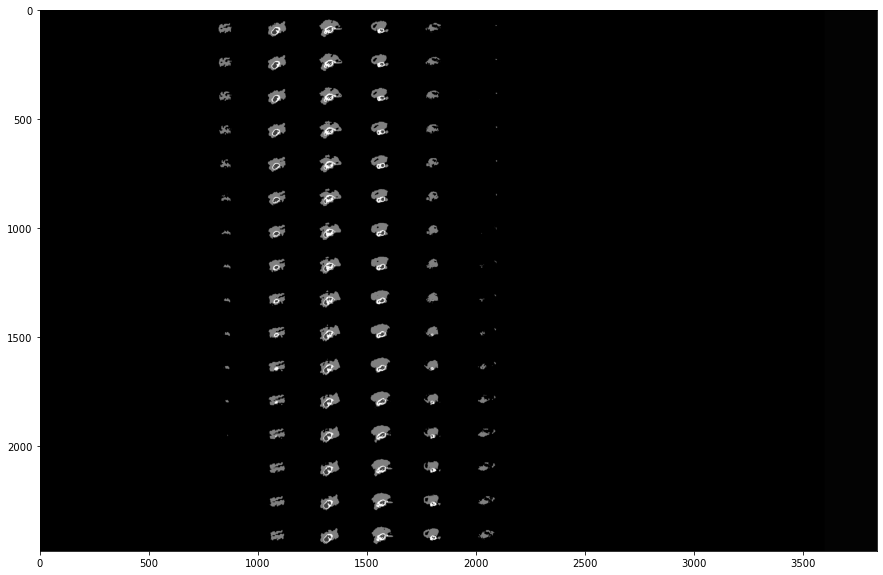

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[:,:,:]), 90, resize=True), cmap ='gray')

#### 3-D Visualization of the Brain and Tumor Region 

In [7]:
# pip install plotly
import plotly.graph_objects as go

from skimage import measure
from skimage.draw import ellipsoid
# Importing image from dataset.
brain_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii"
seg_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii"

im = nib.load(brain_path).get_fdata()
seg = nib.load(seg_path).get_fdata()
print(seg.shape)
print(im.shape)

(240, 240, 155)
(240, 240, 155)


In [8]:
verts, faces, normals, values = measure.marching_cubes(im, 0)
x, y, z = verts.T
i, j, k = faces.T

mesh1 = go.Mesh3d(x=x, y=y, z=z,color='royalblue', opacity=0.5, i=i, j=j, k=k)

verts, faces, normals, values = measure.marching_cubes(seg, 2)
x, y, z = verts.T
i, j, k = faces.T

mesh2 = go.Mesh3d(x=x, y=y, z=z, color='red', opacity=0.5, i=i, j=j, k=k)
bfig = go.Figure(data=[mesh1, mesh2])
bfig.show()

#### Showing different Segments of Tumor for Patient 002

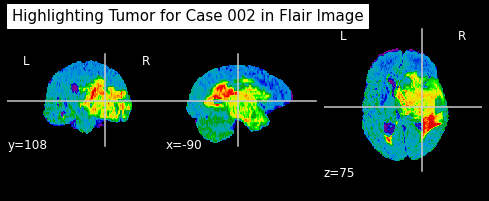

In [9]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')


nlplt.plot_epi(niimg,
               title='Highlighting Tumor for Case 002 in Flair Image')


plt.show()

## Model: U-Net for Biomedical Image Segmentation

This project utilizes a U-Net based model for precise segmentation of MRI images. U-Net stands as a seminal architecture in medical image analysis, renowned for its efficacy in segmenting anatomical structures across diverse imaging modalities. Its unique U-shaped design, comprising a contracting and expansive pathway, addresses the intricate challenges of semantic segmentation tasks. 

The contracting pathway acts as a feature extractor, capturing contextual information through successive convolutional layers. Subsequently, the expansive pathway utilizes upsampling layers to refine segmentation boundaries, ensuring accurate delineation of target structures.

![](https://github.com/SayanPal27/CerebraScan---Brain-Tumor-Segmentation/blob/main/WhatsApp%20Image%202024-05-08%20at%2013.45.02_8a357fca.jpg?raw=true)



#### Loss Function

The **Dice coefficient** is a measure of overlap between two samples, ranging from 0 to 1. A Dice coefficient of 1 denotes perfect and complete overlap. Originally developed for binary data, it can be calculated using the formula:

![Dice Loss Formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

In [10]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


#### Building U-Net Model

In [11]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input

def build_compact_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck layer
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    
    # Upsampling layers
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(up7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
    
    conv8 = Conv2D(4, (1,1), activation='softmax')(conv7)
    
    return Model(inputs=inputs, outputs=conv8)

IMG_SIZE=128
input_layer = Input((IMG_SIZE, IMG_SIZE, 4))
model = build_compact_unet(input_layer, 'he_normal', 0.2)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Check model summary
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

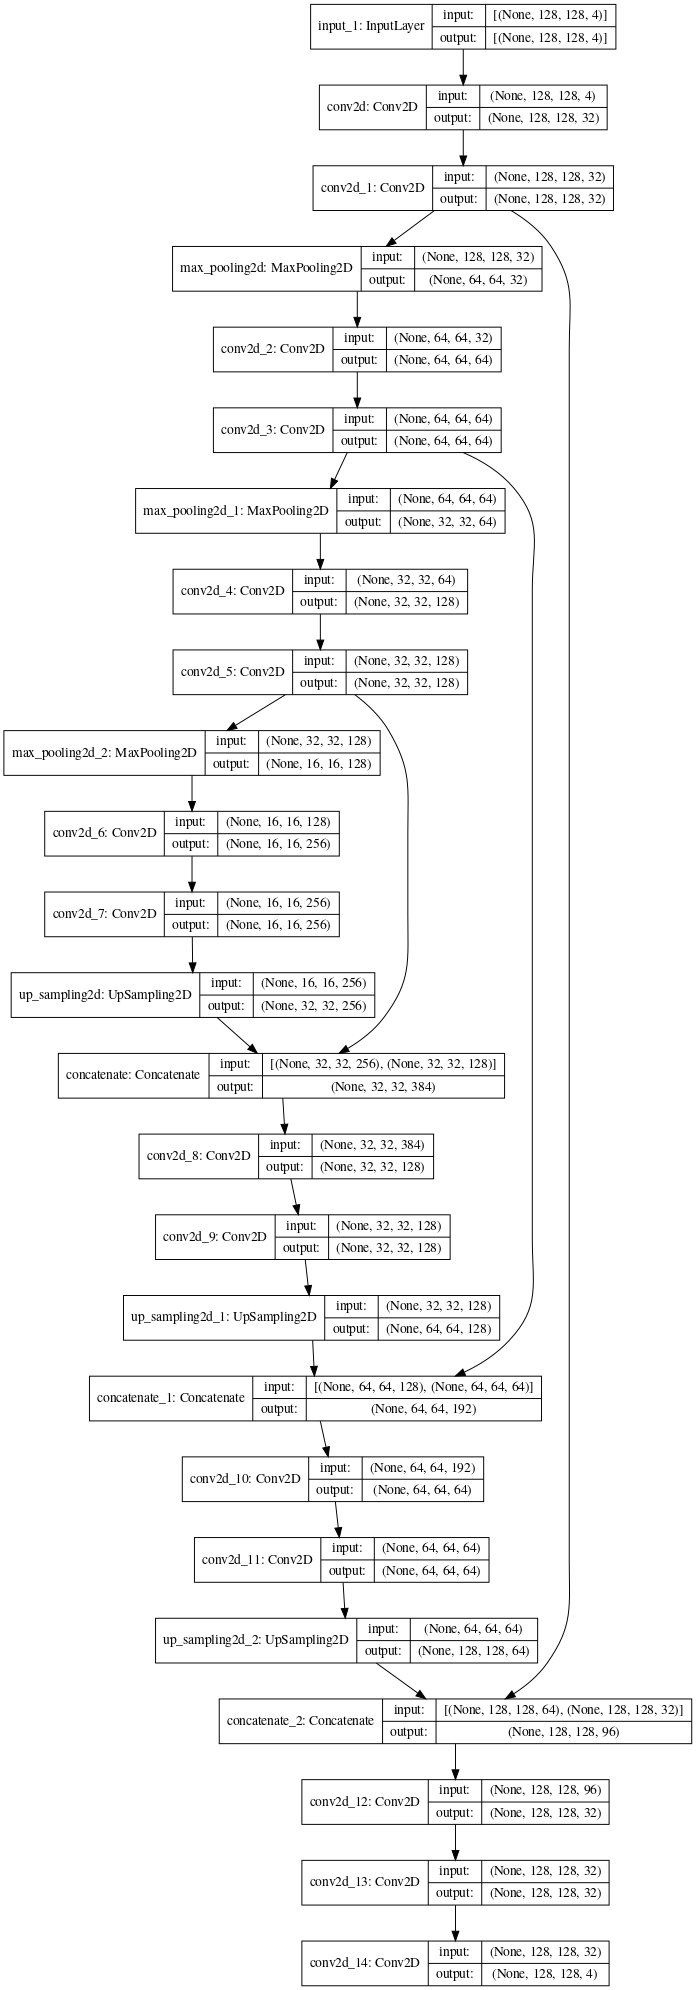

In [12]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

#### Load The Data
Data Generators are made so that we dont have to save data in memory

In [13]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

train_test_ids, test_ids = train_test_split(train_and_test_ids,test_size=0.3) 
train_ids, val_ids = train_test_split(train_test_ids,test_size=0.15) 

In [14]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_t1.nii');
            t1 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_t2.nii');
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,2] = cv2.resize(t1[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,3] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [15]:
print(f'Total Number of Cases = {len(train_ids) + len(val_ids) + len(test_ids)}')
print(f'Number of cases in the training dataset: {len(train_ids)}')
print(f'Number of cases in the validation dataset: {len(val_ids)}')
print(f'Number of cases in the test dataset: {len(test_ids)}')

Total Number of Cases = 368
Number of cases in the training dataset: 218
Number of cases in the validation dataset: 39
Number of cases in the test dataset: 111


#### Train - Val - Test Split

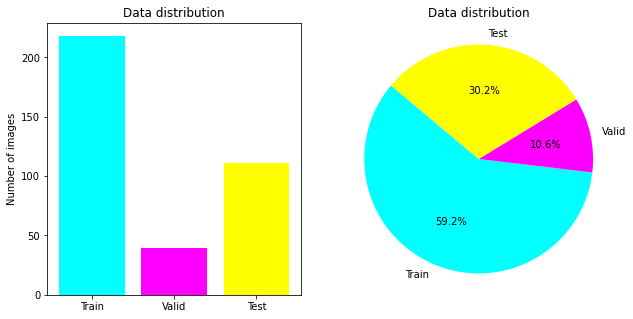

In [16]:
import matplotlib.pyplot as plt

def showDataLayout():
    # Data
    train_count = len(train_ids)
    val_count = len(val_ids)
    test_count = len(test_ids)
    total_count = train_count + val_count + test_count
    data_counts = [train_count, val_count, test_count]
    labels = ["Train", "Valid", "Test"]
    colors = ['cyan', 'magenta', 'yellow']
    
    # Bar plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(labels, data_counts, align='center', color=colors)
    plt.ylabel('Number of images')
    plt.title('Data distribution')
    
    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(data_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Data distribution')
    
    plt.show()

showDataLayout()

In [17]:
csv_logger = CSVLogger('training.log', separator=',', append=False)

callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
        csv_logger
    ]

#### Training model 
##### Epochs - 20
##### Training Examples - 218



In [18]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=20,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )  
model.save("CerebraScan_Model.h5")

Epoch 1/20
218/218 [==============================] - 287s 1s/step - loss: 0.2819 - accuracy: 0.9580 - val_loss: 0.0718 - val_accuracy: 0.9789
Epoch 2/20
218/218 [==============================] - 99s 455ms/step - loss: 0.0732 - accuracy: 0.9815 - val_loss: 0.0738 - val_accuracy: 0.9789
Epoch 3/20
218/218 [==============================] - 81s 370ms/step - loss: 0.0699 - accuracy: 0.9820 - val_loss: 0.0609 - val_accuracy: 0.9794
Epoch 4/20
218/218 [==============================] - 82s 375ms/step - loss: 0.0642 - accuracy: 0.9835 - val_loss: 0.0633 - val_accuracy: 0.9827
Epoch 5/20
218/218 [==============================] - 82s 374ms/step - loss: 0.0648 - accuracy: 0.9824 - val_loss: 0.0616 - val_accuracy: 0.9817

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/20
218/218 [==============================] - 83s 380ms/step - loss: 0.0533 - accuracy: 0.9843 - val_loss: 0.0527 - val_accuracy: 0.9833
Epoch 7/20
218/218 [==============================

#### Plot Train and Validation Accuracy

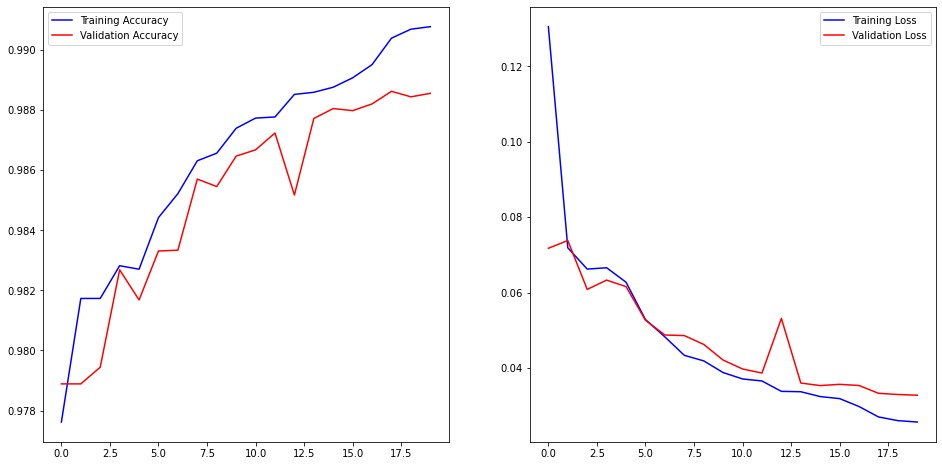

In [19]:
path = '/kaggle/working/CerebraScan_Model.h5'
model = keras.models.load_model(path, 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/kaggle/working/training.log', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']


f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

plt.show()

#### Predict for Random Samples

 Case No. : 047
3/3 [==============================] - 1s 142ms/step
64


<Figure size 1296x3600 with 0 Axes>

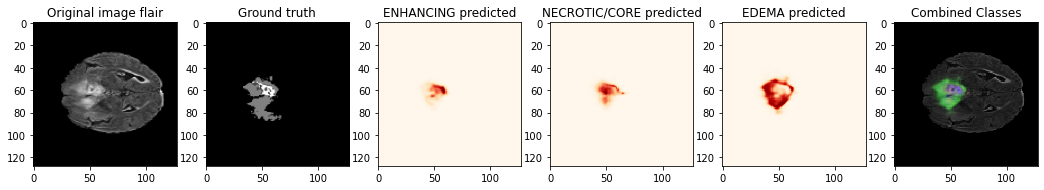

 Case No. : 131
3/3 [==============================] - 0s 35ms/step
64


<Figure size 1296x3600 with 0 Axes>

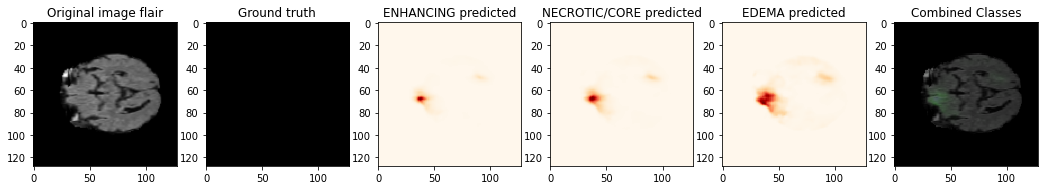

 Case No. : 322
3/3 [==============================] - 0s 46ms/step
64


<Figure size 1296x3600 with 0 Axes>

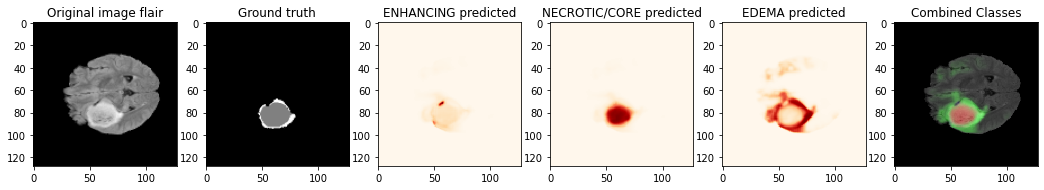

 Case No. : 208
3/3 [==============================] - 0s 34ms/step
64


<Figure size 1296x3600 with 0 Axes>

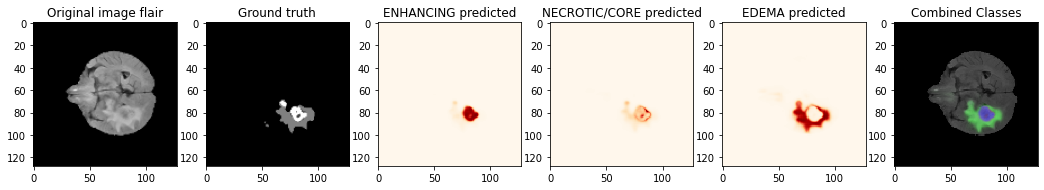

 Case No. : 200
3/3 [==============================] - 0s 35ms/step
64


<Figure size 1296x3600 with 0 Axes>

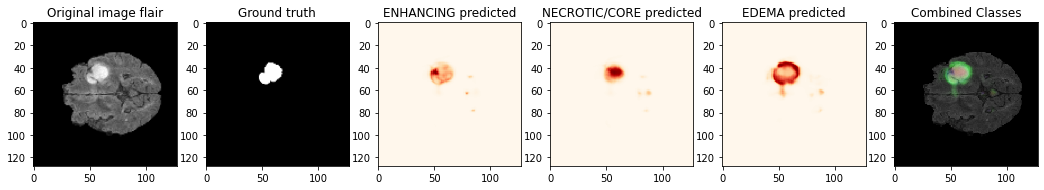

 Case No. : 197
3/3 [==============================] - 0s 33ms/step
64


<Figure size 1296x3600 with 0 Axes>

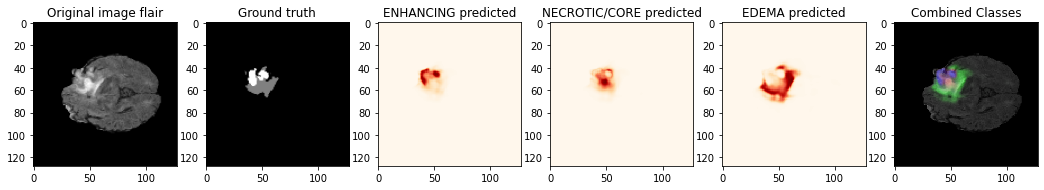

 Case No. : 173
3/3 [==============================] - 0s 33ms/step
64


<Figure size 1296x3600 with 0 Axes>

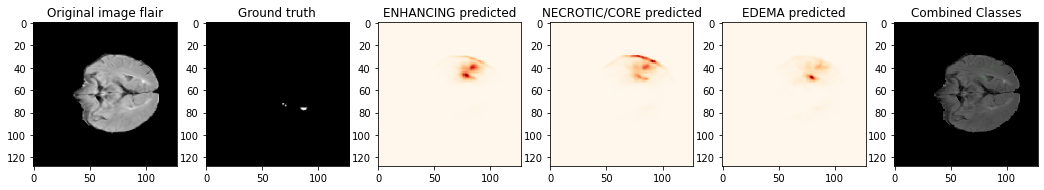

 Case No. : 050
3/3 [==============================] - 0s 33ms/step
64


<Figure size 1296x3600 with 0 Axes>

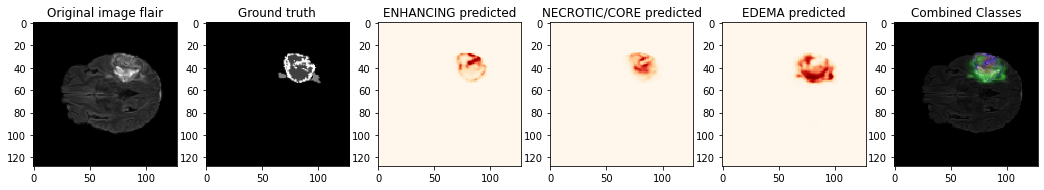

 Case No. : 273
3/3 [==============================] - 0s 33ms/step
64


<Figure size 1296x3600 with 0 Axes>

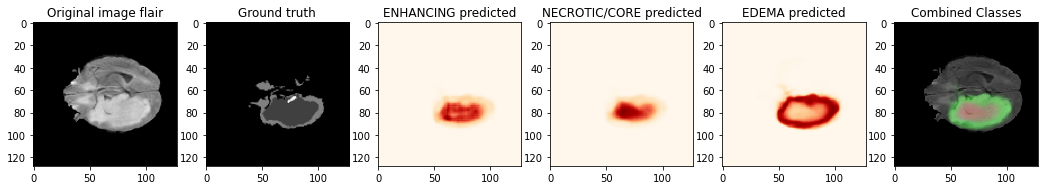

 Case No. : 307
3/3 [==============================] - 0s 33ms/step
64


<Figure size 1296x3600 with 0 Axes>

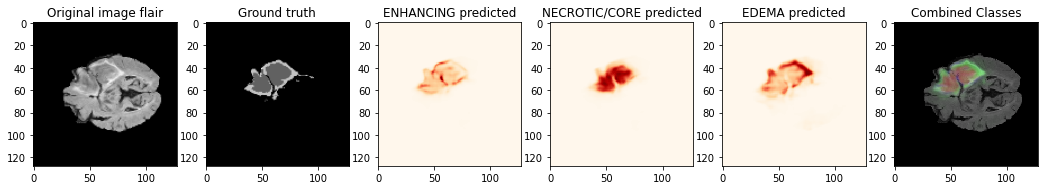

 Case No. : 086
3/3 [==============================] - 0s 33ms/step
64


<Figure size 1296x3600 with 0 Axes>

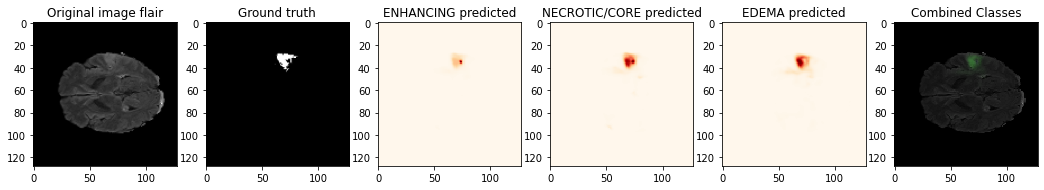

 Case No. : 301


KeyboardInterrupt: 

In [20]:
def predictByPath(case_path, case):
    # Load MRI images
    vol_path_flair = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path_flair).get_fdata()
    
    vol_path_t1ce = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path_t1ce).get_fdata() 
    
    vol_path_t1 = os.path.join(case_path, f'BraTS20_Training_{case}_t1.nii')
    t1 = nib.load(vol_path_t1).get_fdata() 
    
    vol_path_t2 = os.path.join(case_path, f'BraTS20_Training_{case}_t2.nii')
    t2 = nib.load(vol_path_t2).get_fdata() 
    
    # Initialize X with empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4))
    
    # Fill X with resized MRI images
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j,:,:,2] = cv2.resize(t1[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j,:,:,3] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        
    # Predict using the model and return the result
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice=40):
    # Load ground truth and original image
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    
    # Predict using the model
    p = predictByPath(path, case)

    # Extract different classes
    core = p[:,:,:,1]
    edema = p[:,:,:,2]
    enhancing = p[:,:,:,3]

    # Plotting
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50)) 

    # Display original image and ground truth
    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    print(start_slice+VOLUME_START_AT)
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    axarr[1].imshow(cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[1].title.set_text('Ground truth')
    
    # Display predicted classes
    axarr[2].imshow(enhancing[start_slice,:,],cmap="OrRd" , interpolation='none')
    axarr[2].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

    axarr[3].imshow(core[start_slice,:,],cmap="OrRd" , interpolation='none')
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')

    axarr[4].imshow(edema[start_slice,:,],cmap="OrRd" , interpolation='none')
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')

    axarr[5].imshow(p[start_slice,:,:,1:4], cmap="hot", interpolation='none', alpha=0.5)
    axarr[5].title.set_text('Combined Classes')

    plt.show()


    
# tot = (train_ids+test_ids+val_ids)

    
# Show predictions for each case
# test_ids.sort()
# for case in tot:
for case in test_ids:
    print(f' Case No. : {case[-3:]}')
    showPredictsById(case[-3:])


#### Comparison with Ground Truth

3/3 [==============================] - 0s 33ms/step


<Figure size 432x288 with 0 Axes>

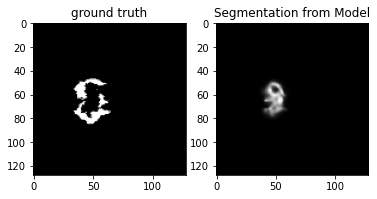

3/3 [==============================] - 0s 33ms/step


<Figure size 432x288 with 0 Axes>

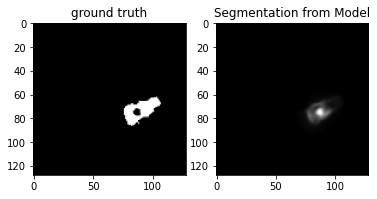

3/3 [==============================] - 0s 33ms/step


<Figure size 432x288 with 0 Axes>

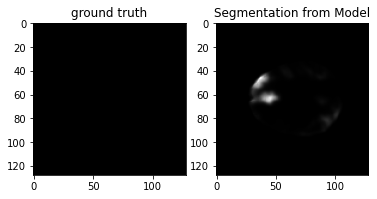

3/3 [==============================] - 0s 34ms/step


<Figure size 432x288 with 0 Axes>

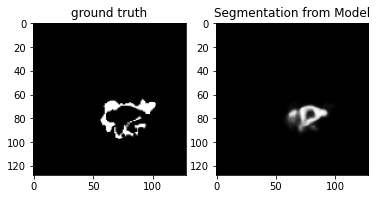

3/3 [==============================] - 0s 33ms/step


<Figure size 432x288 with 0 Axes>

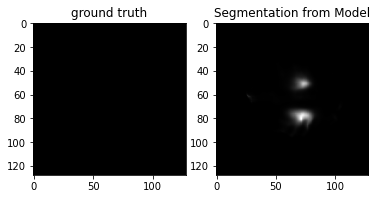

3/3 [==============================] - 0s 33ms/step


<Figure size 432x288 with 0 Axes>

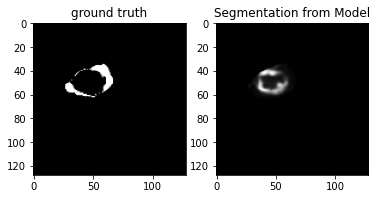

3/3 [==============================] - 0s 34ms/step


<Figure size 432x288 with 0 Axes>

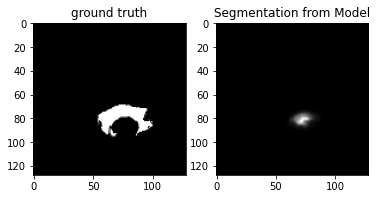

3/3 [==============================] - 0s 33ms/step


<Figure size 432x288 with 0 Axes>

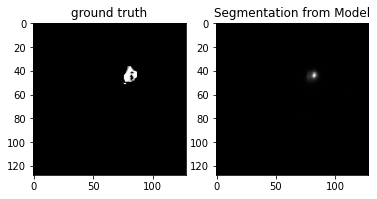

3/3 [==============================] - 0s 34ms/step


<Figure size 432x288 with 0 Axes>

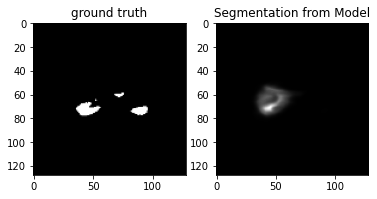

3/3 [==============================] - 0s 33ms/step


<Figure size 432x288 with 0 Axes>

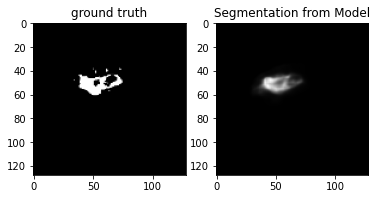

3/3 [==============================] - 0s 33ms/step


<Figure size 432x288 with 0 Axes>

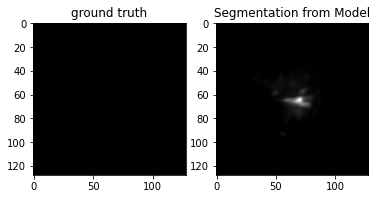

KeyboardInterrupt: 

In [21]:
for i in range(len(test_ids)):
#     case = case=test_ids[3][-3:]
    case = case=test_ids[i][-3:]
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    p = predictByPath(path,case)


    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]


    i=74# slice at
    eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



    gt[gt != eval_class] = 1 # use only one class for per class evaluation 

    resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    plt.figure()
    f, axarr = plt.subplots(1,2) 
    axarr[0].imshow(resized_gt, cmap="gray")
    axarr[0].title.set_text('ground truth')
    axarr[1].imshow(p[i,:,:,3], cmap="gray")
    axarr[1].title.set_text(f'Segmentation from Model')
    plt.show()

#### Statistics on Test Data

In [22]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
111/111 [==============================] - 118s 1s/step - loss: 0.0298 - accuracy: 0.9893 - mean_io_u_1: 0.8051 - dice_coef: 0.4994 - precision: 0.9915 - sensitivity: 0.9867 - specificity: 0.9971 - dice_coef_necrotic: 0.4113 - dice_coef_edema: 0.6125 - dice_coef_enhancing: 0.5001
test loss, test acc: [0.029735995456576347, 0.9897240996360779, 0.8054969906806946, 0.48719996213912964, 0.9917628765106201, 0.9872358441352844, 0.9972069263458252, 0.40506452322006226, 0.588640034198761, 0.4694620966911316]


#### Evaluation on Test Data

In [23]:
from sklearn.metrics import classification_report

# Define a function to get predictions for test data
def get_predictions(model, generator):
    predictions = []
    ground_truth = []
    for i in range(len(generator)):
        X, y = generator[i]
        batch_predictions = model.predict(X)
        predictions.extend(batch_predictions)
        ground_truth.extend(y)
    return np.array(predictions), np.array(ground_truth)

# Get predictions for the test data
test_predictions, test_ground_truth = get_predictions(model, test_generator)

# Reshape predictions and ground truth to match the required format for classification_report
test_predictions_flat = np.argmax(test_predictions, axis=-1).flatten()
test_ground_truth_flat = np.argmax(test_ground_truth, axis=-1).flatten()

# Generate the classification report
report = classification_report(test_ground_truth_flat, test_predictions_flat, target_names=[SEGMENT_CLASSES[i] for i in range(4)])

print(report)

               precision    recall  f1-score   support

    NOT tumor       1.00      1.00      1.00 150085896
NECROTIC/CORE       0.57      0.39      0.46    596551
        EDEMA       0.60      0.59      0.59   1562886
    ENHANCING       0.59      0.49      0.53    519083

     accuracy                           0.99 152764416
    macro avg       0.69      0.62      0.65 152764416
 weighted avg       0.99      0.99      0.99 152764416

